# 1. 加载数据

In [3]:
import scipy 
import os
import socket
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
from imp import reload

from dataset import generate_random_layout, wireframeDataset_Rplan
from models import Generator, WireframeDiscriminator, weight_init
import utils
reload(utils)
from utils import get_figure,draw_table,bounds_check

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

ModuleNotFoundError: No module named 'tensorboardX'

In [3]:
torch.__version__

'1.6.0'

In [35]:
import main
reload(main)
from main import setup
cfg = setup(None)
device = torch.device(cfg.MANUAL.DEVICE)
date = cfg.MANUAL.DATE
time_ = cfg.MANUAL.TIME
cfg.merge_from_file("config.yaml")
cfg

CfgNode({'SYSTEM': CfgNode({'NUM_GPUS': 2, 'NUM_WORKERS': 4, 'HOSTNAMES': ['ubuntuStation', 'DESKTOP-HRFSC59', 'Work-Station', 'LAPTOP-LUOZN', 'DESKTOP-57EV4E4']}), 'DATASET': CfgNode({'NAME': 'rplan', 'SUBSET': 'names_0-1_1-1_2-1_3-1_4-0_5-0_6-0_7-1_8-0_9-1.pkl', 'BATCHSIZE': 128}), 'MODEL': CfgNode({'GENERATOR': CfgNode({}), 'RENDERER': CfgNode({'RENDERING_SIZE': 64}), 'DISCRIMINATOR': CfgNode({})}), 'TRAIN': CfgNode({'LEARNING_RATE': 2e-05, 'NUM_EPOCHS': 3000}), 'TENSORBOARD': CfgNode({'SAVE_INTERVAL': 100}), 'PATH': CfgNode({'RPLAN': ['../../data_RPLAN/pkls', 'D:\\luozn\\data_RPLAN\\pkls', 'F:\\luozn\\data_RPLAN\\pkls', 'E:\\Seafile\\data_RPLAN\\pkls', 'E:\\Seafile\\data_RPLAN\\pkls'], 'Z_FILE': 'fixed_z/fixed_xywh_rplan_1030.pkl', 'LOG_DIR': 'runs_rplan'}), 'MANUAL': CfgNode({'HOSTNAME': 'Work-Station', 'RPLAN_PATH': 'F:\\luozn\\data_RPLAN\\pkls', 'DEVICE': 'cuda:0', 'DATE': '2021-10-30', 'TIME': '20-40-11'})})

# 2. LayoutGAN模型

### 2.1 dataset

In [5]:
print('using dataset:\t{}'.format(cfg.DATASET.NAME))
print('hostname:\t{}'.format(cfg.MANUAL.HOSTNAME))
print('date:\t\t{}'.format(cfg.MANUAL.DATE))

using dataset:	rplan
hostname:	Work-Station
date:		2021-10-30


In [6]:
import dataset
reload(dataset)
from dataset import generate_random_layout, wireframeDataset_Rplan

real_dataset = wireframeDataset_Rplan(cfg)
checkpoint = './params/params_rplan_{0}.pkl'.format(date)
log_dir = cfg.PATH.LOG_DIR
batch_size = cfg.DATASET.BATCHSIZE
real_dataloader = DataLoader(real_dataset,batch_size,shuffle=True,num_workers=0,drop_last=True)

100%|██████████| 19154/19154 [00:00<00:00, 32831.51it/s]


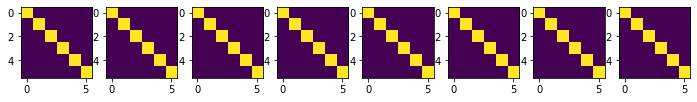

In [7]:
fake_images = generate_random_layout(real_dataset,batch_size=8)
plt.figure(figsize=(12,5))
for i in range(fake_images[0].shape[0]):
    plt.subplot(1,fake_images[0].shape[0],i+1)
    plt.imshow(fake_images[0][i,:,:-4])
plt.show()
#fake_images[0][0,:,:-4]

In [8]:
#固定的随机layout
#fixed_z_file = './fixed_z/fixed_xyaw_{0}_{1}.pkl'.format(dataset,'_'.join([str(r) for r in rooms]))
fixed_z_file = cfg.PATH.Z_FILE
if not os.path.exists(fixed_z_file):
    fixed = generate_random_layout(real_dataset, 8)
    #fixed_images = [torch.tensor(x).to(device) for x in fixed]
    with open(fixed_z_file, 'wb') as output:
        pickle.dump(fixed,output)
    print('generating'+ fixed_z_file)

In [9]:
with open(fixed_z_file, 'rb') as pkl_file:
    fixed_z = pickle.load(pkl_file)
fixed_z = [torch.tensor(x).to(device) for x in fixed_z]
fixed_z[0].shape

torch.Size([8, 6, 10])

### 2.3 初始化

In [13]:
######################################################
learning_rate = cfg.TRAIN.LEARNING_RATE
num_epochs = cfg.TRAIN.NUM_EPOCHS
tensorboard_interval = cfg.TENSORBOARD.SAVE_INTERVAL
tensorboard = True
discriminator_losses=[]
generator_losses=[]
boundray_losses=[]
gradient_penalties = []
######################################################

import models
reload(models)
from models import Generator, WireframeDiscriminator, weight_init, renderer_g2v

renderer = renderer_g2v(
    render_size=cfg.MODEL.RENDERER.RENDERING_SIZE, 
    class_num=real_dataset.enc_len
    )

generator = Generator(dataset=real_dataset)
generator.apply(weight_init)
generator = nn.DataParallel(generator)
generator.to(device)

discriminator = WireframeDiscriminator(dataset=real_dataset, renderer=renderer)
discriminator.apply(weight_init)
discriminator = nn.DataParallel(discriminator)
discriminator.to(device)


#Initialize optimizers.
generator_optimizer = optim.Adam(generator.parameters(), learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), learning_rate)#Wasserstein GAN推荐使用RMSProp优化

if os.path.exists(checkpoint):
    checkpoint = torch.load(checkpoint)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    epoch_last = checkpoint['epoch']
    n_iter = checkpoint['n_iter']
    print('load_previous_model')
else:
    epoch_last = 0
    # global step
    n_iter = -1
    print('create_new_model')

create_new_model


In [14]:
print('amount of parameters in generator:\t',sum(p.numel() for p in generator.parameters() if p.requires_grad))
print('amount of parameters in discriminator:\t',sum(p.numel() for p in discriminator.parameters() if p.requires_grad))

amount of parameters in generator:	 151585295
amount of parameters in discriminator:	 17814785


### 检查rasterazition

In [15]:
batch = iter(real_dataloader).next()
batch = [x.to(device) for x in batch]
batch

[tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.5254, 0.2930, 0.4648],
          [0.0000, 1.0000, 0.0000,  ..., 0.7246, 0.1797, 0.2383],
          [0.0000, 0.0000, 1.0000,  ..., 0.2207, 0.1562, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.5254, 0.1055, 0.1367],
          [0.0000, 0.0000, 0.0000,  ..., 0.3242, 0.1797, 0.2422],
          [0.0000, 0.0000, 0.0000,  ..., 0.8066, 0.2188, 0.0742]],
 
         [[1.0000, 0.0000, 0.0000,  ..., 0.4551, 0.4297, 0.4414],
          [0.0000, 1.0000, 0.0000,  ..., 0.5996, 0.1914, 0.2383],
          [0.0000, 0.0000, 1.0000,  ..., 0.3164, 0.1016, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.3867, 0.1016, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.6055, 0.1328, 0.2266],
          [0.0000, 0.0000, 0.0000,  ..., 0.7285, 0.1953, 0.0820]],
 
         [[1.0000, 0.0000, 0.0000,  ..., 0.4961, 0.3594, 0.4531],
          [0.0000, 1.0000, 0.0000,  ..., 0.6133, 0.2227, 0.2188],
          [0.0000, 0.0000, 1.0000,  ..., 0.2734, 0.0938, 0.1328],
    

In [16]:
generated = generator(batch[0],batch[1])

f:\luozn\Codes\FloorplanGAN\models.py:126: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:918.)
  decoded)) - 0.5 + geo.permute(0, 3, 1, 2)  # 大跨residual connect#(B,4,S,1)


In [17]:
generated[0].shape

torch.Size([128, 6, 10])

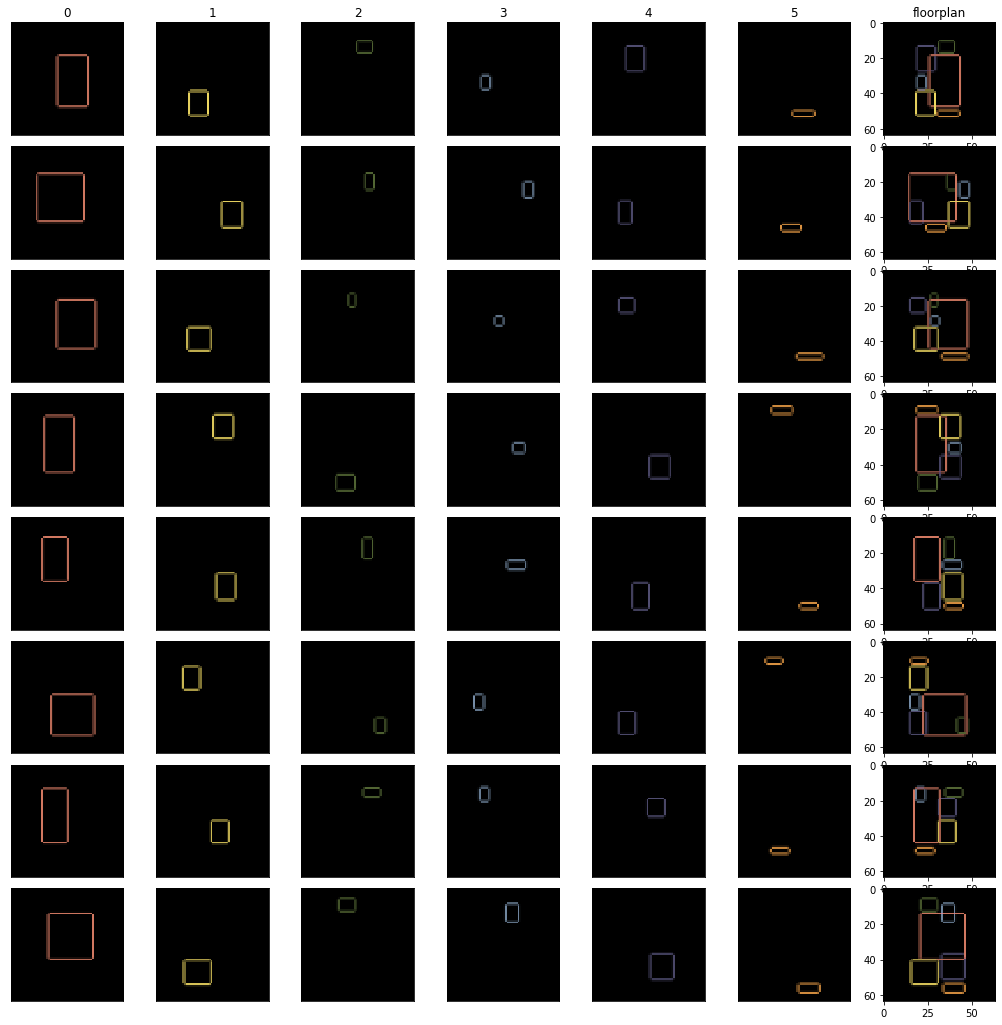

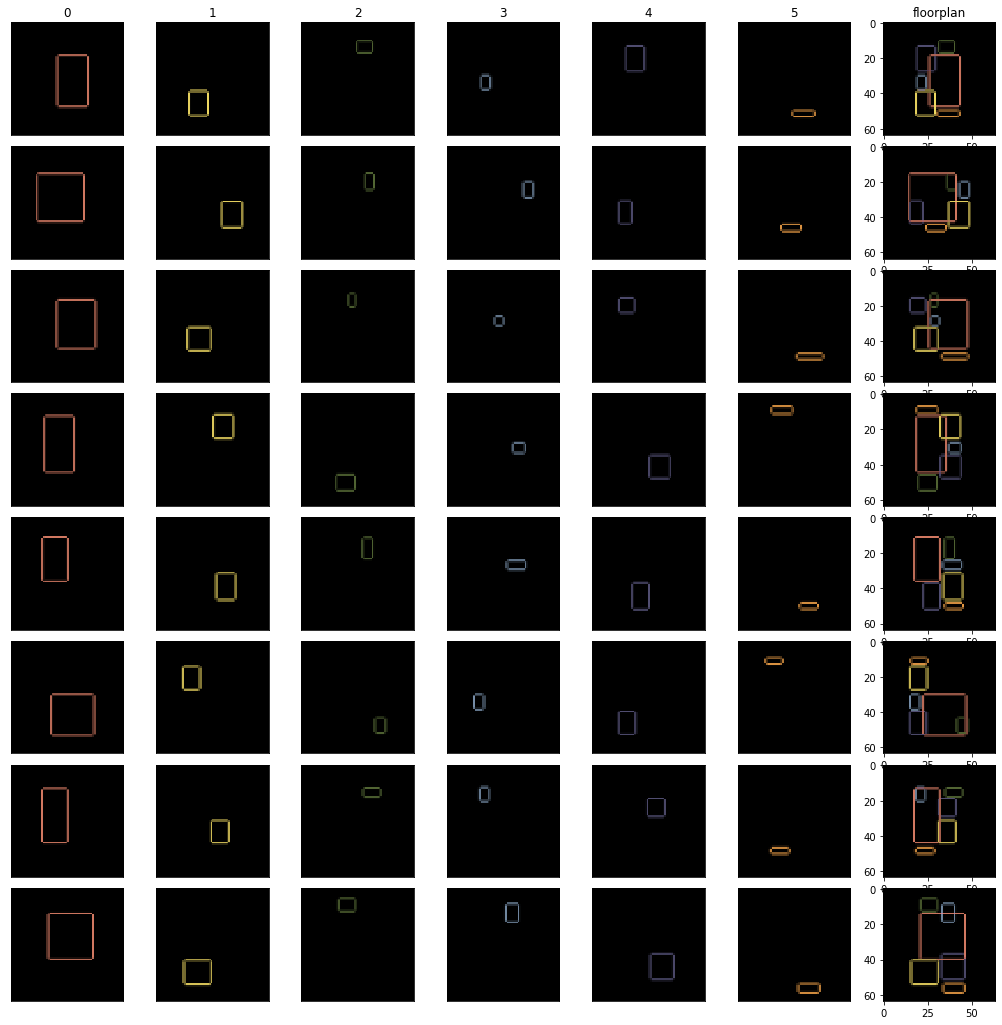

In [22]:
get_figure(renderer.render(generated[0][:8]))

In [23]:
pred = discriminator(batch[0],batch[1])
pred.mean()

tensor(-0.1620, device='cuda:0', grad_fn=<MeanBackward0>)

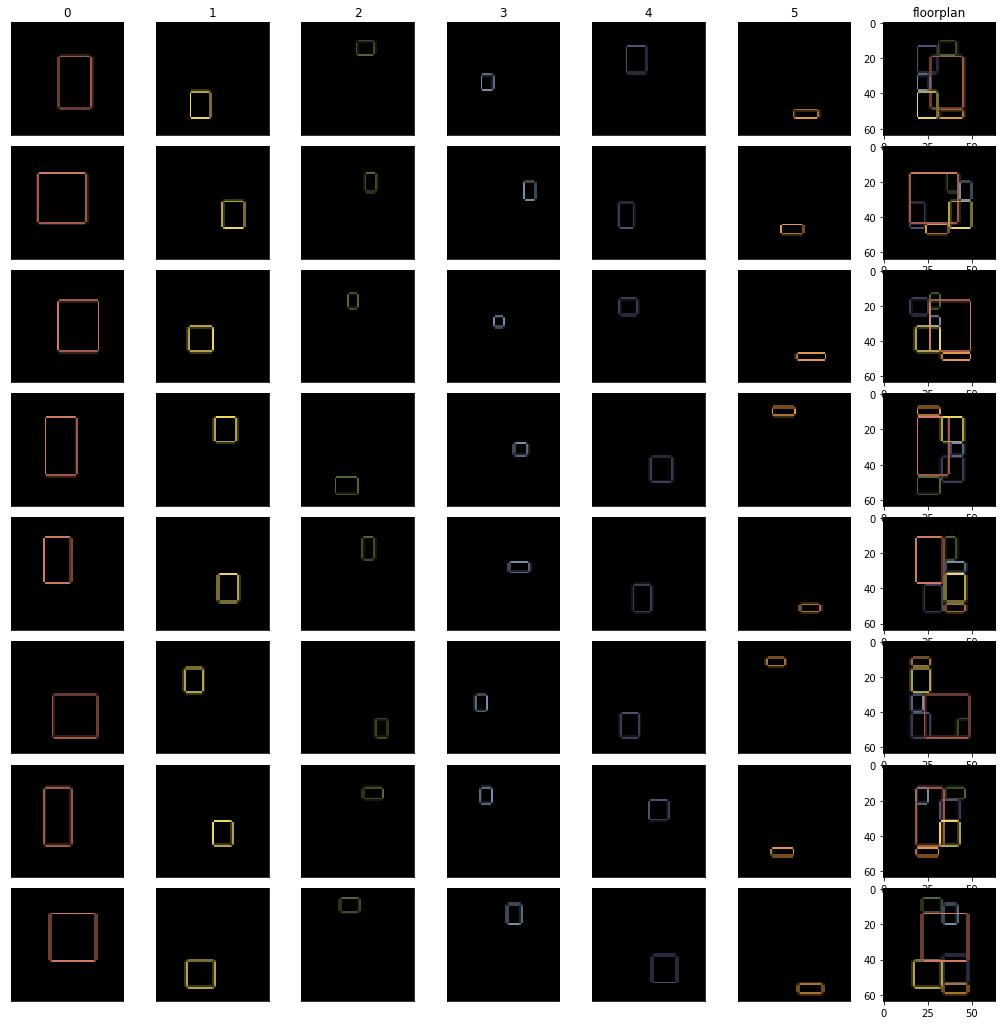

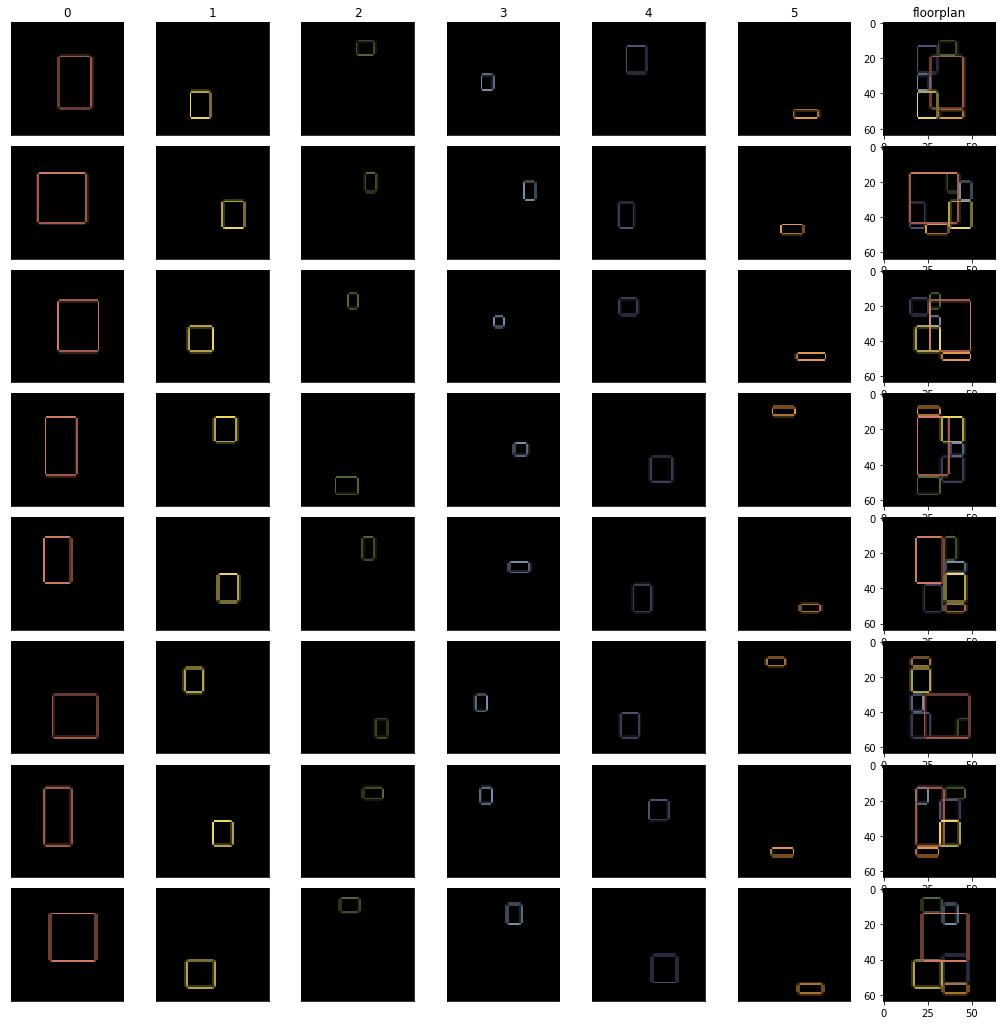

In [25]:
get_figure(renderer.render(batch[0][:8]))

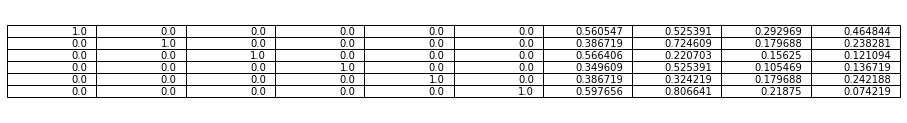

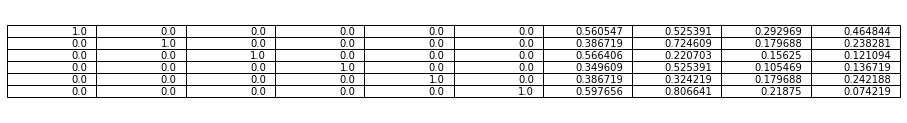

In [28]:
draw_table(batch[0][0])

### 2.4 训练

In [34]:
#log_dir = 'G_test'
if tensorboard:
    writer = SummaryWriter(log_dir=log_dir+'/'+date+' '+time_)

#固定的随机噪声
with open(fixed_z_file, 'rb') as pkl_file:
    fixed_z = pickle.load(pkl_file)
fixed_z = [torch.tensor(x).to(device) for x in fixed_z]
fig_fixed= get_figure(renderer.render(fixed_z[0].detach()))
if tensorboard:
    writer.add_figure('fixed Z Image', fig_fixed, 1)

OSError: [WinError 123] 文件名、目录名或卷标语法不正确。: 'runs_rplan/2021-10-30 17:45:19'

In [ ]:
real_images = iter(real_dataloader).next()
real_images = [x.to(device) for x in real_images]

In [ ]:
random_images = generate_random_layout(real_dataset,batch_size)
random_images = [torch.tensor(x).to(device) for x in random_images]

In [ ]:
get_figure(render(random_images[0][:4])).show()

In [ ]:
fake_images = generator(random_images[0],random_images[1])
get_figure(render(fake_images[0][:4])).show()

In [33]:
# Start training.
for ec in range(num_epochs):
    epoch = ec + epoch_last
    print('Start to train epoch %d.' %(epoch))

    for batch_i, real_images in enumerate(real_dataloader,0):
        n_iter+=1

        print('\t iter {0} | batch {1} of epoch {2}'.format(n_iter, batch_i, epoch))

        '''real_images = [torch.cat([F.relu(torch.normal(mean=real_images[0][:,:,:-4],std=0.02)),\
                                  real_images[0][:,:,-4:]],axis=-1),\
                       real_images[1]]#向真实数据加噪声'''
        real_images = [x.to(device) for x in real_images]

        random_images = generate_random_layout(real_dataset,batch_size)
        random_images = [torch.tensor(x).to(device) for x in random_images]

        '''for parm in discriminator.parameters():
            parm.data.clamp_(-clamp_num, clamp_num)#权重裁剪'''

        # 训练判别器
        generator.eval()
        discriminator.train()
        discriminator.zero_grad()
        pred_real = discriminator(real_images[0], real_images[1])
        pred_real.backward(torch.ones_like(pred_real).to(device))

        fake_images = generator(random_images[0],random_images[1])
        pred_fake = discriminator(fake_images[0].detach(), fake_images[1].detach())
        pred_fake.backward(-torch.ones_like(pred_real).to(device))

        ##Gradient Penalty
        """alpha = torch.rand(batch_size, 1, 1)
        alpha = alpha.expand(real_images[0].size())
        alpha = alpha.to(device)
        interpolates = alpha * real_images[0] + (1 - alpha) * fake_images[0].detach()
        interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
        pred_interpolates = discriminator(interpolates)
        gradients = torch.autograd.grad(outputs=pred_interpolates, inputs=interpolates,
                          grad_outputs=torch.ones(pred_interpolates.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10 #LAMBDA
        gradient_penalty.backward()"""

        discriminator_optimizer.step()
        discriminator_loss = pred_fake.mean() - pred_real.mean() #+ gradient_penalty

        if tensorboard:
            discriminator_losses.append(discriminator_loss.cpu().detach().numpy())

        if (batch_i+1)%2 == 0:
        # 训练生成器
            discriminator.eval()
            generator.train()
            generator.zero_grad()

            boundray_loss = bounds_check(fake_images[0])
            boundray_loss.backward(retain_graph=True)

            pred_fake = discriminator(fake_images[0],fake_images[1])

            pred_fake.backward(torch.ones_like(pred_real).to(device))
            generator_optimizer.step()
            generator_loss = pred_fake.mean()

            if tensorboard:
                generator_losses.append(generator_loss.cpu().detach().numpy())
                boundray_losses.append(boundray_loss.cpu().detach().numpy())

        # TensorboardX
        if n_iter%tensorboard_interval == tensorboard_interval-1:
            discriminator_losses = np.array(discriminator_losses)
            generator_losses = np.array(generator_losses)
            boundray_losses = np.array(boundray_losses)

            print('\t\t N_iter {:7d} | Epoch [{:5d}/{:5d}] | discriminator_loss: {:6.4f} | generator_loss: {:6.4f}'.
                format(n_iter, epoch, num_epochs, discriminator_losses.mean(), generator_losses.mean()))
            if tensorboard:
                generator.eval()
                discriminator.eval()

                #记录梯度
                try:
                    G_grads = [(name,weight.grad.mean()) for name, weight in generator.named_parameters() if weight.requires_grad]
                    writer.add_scalar('G_grads 0 {}'.format(G_grads[0][0]), \
                        G_grads[0][1], n_iter)
                    writer.add_scalar('G_grads -1 {}'.format(G_grads[-1][0]), \
                        G_grads[-1][1], n_iter)
                except:
                    print('G_layer_zero_grad')

                try:
                    D_grads = [(name,weight.grad.mean()) for name, weight in discriminator.named_parameters() if weight.requires_grad]
                    writer.add_scalar('D_grads 0 {}'.format(D_grads[0][0]), \
                        D_grads[0][1], n_iter)
                    writer.add_scalar('D_grads -1 {}'.format(D_grads[-1][0]), \
                        D_grads[-1][1], n_iter)
                except:
                    print('D_layer_zero_grad')

                #记录loss
                writer.add_scalar('Discriminator Loss', discriminator_losses.mean(), n_iter)
                writer.add_scalar('Generator Loss', generator_losses.mean(), n_iter)
                writer.add_scalar('Boundray Loss', boundray_losses.mean(), n_iter)

                #记录网络权重
                for name, param in discriminator.named_parameters():
                    writer.add_histogram('Discriminator: '+ name, param.clone().detach().cpu().data.numpy(), n_iter)
                for name, param in generator.named_parameters():
                    writer.add_histogram('Generator: '+ name, param.clone().detach().cpu().data.numpy(), n_iter)

                #每个epoch向tensorboard添加recall

                real_pred = pred_real.detach().cpu().numpy()
                random_pred = discriminator(random_images[0],random_images[1]).detach().cpu().numpy()
                fake_pred = pred_fake.detach().cpu().numpy()

                acc = plt.figure(figsize=(10,5))
                ax = acc.add_subplot(111)
                ax.hist(real_pred,alpha=0.5, density=True,bins=60)
                ax.hist(random_pred,alpha=0.5, density=True,bins=60)
                ax.hist(fake_pred,alpha=0.5, density=True,bins=60)
                ax.legend(['real_pred','random_pred','fake_pred'])
                writer.add_figure('prediction',acc, n_iter)


                #可视化真实图像,添加到tensorboard
                fig_real= get_figure(renderer.render(real_images[0][:8]))
                writer.add_figure('Real Image',fig_real,n_iter)

                #可视化Z生成图像
                generated_z = generator(fixed_z[0],fixed_z[1])
                fig_fake = get_figure(renderer.render(generated_z[0]))
                writer.add_figure('Fake Image',fig_fake, n_iter)

                table = draw_table(generated_z[0][4])
                writer.add_figure('generated[4]',table, n_iter)

            discriminator_losses=[]
            generator_losses=[]
            boundray_losses=[]


    #在确认模型有效之前，暂不保存模型参数
    torch.save({
            'generator_state_dict': generator.state_dict(),
            'generator_optimizer_state_dict': generator_optimizer.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
            'epoch': epoch,
            'n_iter':n_iter,
            }, checkpoint)
    print('\tparams saved to '+ checkpoint)

if tensorboard:
    writer.close()

Start to train epoch 0.
	 iter 4 | batch 0 of epoch 0
	 iter 5 | batch 1 of epoch 0
	 iter 6 | batch 2 of epoch 0
	 iter 7 | batch 3 of epoch 0
	 iter 8 | batch 4 of epoch 0
	 iter 9 | batch 5 of epoch 0
	 iter 10 | batch 6 of epoch 0
	 iter 11 | batch 7 of epoch 0
	 iter 12 | batch 8 of epoch 0
	 iter 13 | batch 9 of epoch 0
	 iter 14 | batch 10 of epoch 0
	 iter 15 | batch 11 of epoch 0
	 iter 16 | batch 12 of epoch 0
	 iter 17 | batch 13 of epoch 0
	 iter 18 | batch 14 of epoch 0
	 iter 19 | batch 15 of epoch 0
	 iter 20 | batch 16 of epoch 0
	 iter 21 | batch 17 of epoch 0
	 iter 22 | batch 18 of epoch 0
	 iter 23 | batch 19 of epoch 0
	 iter 24 | batch 20 of epoch 0
	 iter 25 | batch 21 of epoch 0
	 iter 26 | batch 22 of epoch 0
	 iter 27 | batch 23 of epoch 0
	 iter 28 | batch 24 of epoch 0
	 iter 29 | batch 25 of epoch 0
	 iter 30 | batch 26 of epoch 0
	 iter 31 | batch 27 of epoch 0
	 iter 32 | batch 28 of epoch 0
	 iter 33 | batch 29 of epoch 0
	 iter 34 | batch 30 of epoch 0


NameError: name 'writer' is not defined

In [ ]:
writer.close()

In [ ]:
generator.apply(weight_init)


In [ ]:
generator.module.encoder_fc0.weight

In [ ]:
pred_real = discriminator(real_images[0])
discriminator_real_loss = real_loss(pred_real, smooth=0.9)
discriminator_real_loss

In [ ]:
fake_images = generator(random_images[0],random_images[1])
pred_fake = discriminator(fake_images[0].detach())
discriminator_fake_loss = fake_loss(pred_fake, smooth=0.1)#label smoothing
discriminator_fake_loss

In [ ]:
pred_fake = discriminator(fake_images[0])
generator_loss = real_loss(pred_fake, False)
generator_loss

In [ ]:
random_images2 = generate_random_layout(real_dataset,batch_size)
random_images2 = [torch.tensor(x).to(device) for x in random_images2]
fake_images2 = generator(random_images2[0],random_images2[1])
pred_fake2 = discriminator(fake_images2[0])
generator_loss2 = real_loss(pred_fake2, False)
generator_loss2

In [ ]:
for name, param in generator.named_parameters():
    print(name,param.clone().detach().cpu().data.numpy())

In [ ]:
param

In [ ]:
param.detach().cpu().data.numpy()

In [ ]:
writer.close()

In [ ]:
pred_fake

In [ ]:
discriminator.train()
generator.train()

real_images = iter(real_dataloader).next()
real_images = [torch.cat([torch.normal(mean=real_images[0][:,:,:-2],std=0.02),real_images[0][:,:,-2:]],axis=-1),real_images[1]]#向真实数据加噪声
real_images = [x.to(device) for x in real_images]

random_images = generate_random_layout(real_dataset,batch_size)
random_images = [torch.tensor(x).to(device) for x in random_images]

fake_images = generator(random_images[0],random_images[1])

In [ ]:
real_images[0][0]

In [ ]:
get_figure(render(real_images[0][:8])).show()
#fake_images

In [ ]:
elements = real_images[0][:8]
batch_size = elements.shape[0]
num_elements =elements.shape[1]#batch_size,46,13
rects = elements[:,:,-4:]#batch_size,46,4
class_ = elements[:,:,:-4]#batch_size,46,9

coor_x = torch.arange(64).unsqueeze(1).expand(64,64).T\
        .expand(batch_size,num_elements,64,64).to(device)
coor_y = coor_x.transpose(2,3).to(device)

x = rects[:,:,0].reshape(batch_size,-1,1,1)*64#batch_size,46,1,1
y = rects[:,:,1].reshape(batch_size,-1,1,1)*64
area_root = rects[:,:,2].reshape(batch_size,-1,1,1)*64**2
w = (area*aspect_ratio)**0.5

h = area/w
try:
    h[h != h] = 0
except:
    pass

x0 = x-0.5*w
x1 = x+0.5*w
y0 = y-0.5*h
y1 = y+0.5*h 

In [ ]:
h

In [ ]:
# 训练判别器
pred_real = discriminator(real_images[0])
discriminator_real_loss = real_loss(pred_real, smooth=0.8)#label smoothing

fake_images = generator(random_images[0],random_images[1])
pred_fake = discriminator(fake_images[0].detach())
discriminator_fake_loss = fake_loss(pred_fake, smooth=0.2)#label smoothing

discriminator_loss = discriminator_real_loss + discriminator_fake_loss

In [ ]:
discriminator_loss

In [ ]:
discriminator.zero_grad()
discriminator_loss.backward()

discriminator_optimizer.step()
discriminator_scheduler.step()

In [ ]:
D_grads = [(name,weight.grad.mean()) for name, weight in discriminator.named_parameters() if weight.requires_grad]
D_grads

In [ ]:
# 训练生成器
pred_fake = discriminator(fake_images[0])
generator_loss = real_loss(pred_fake, False)
pred_fake

In [ ]:
generator_loss

In [ ]:
generator.zero_grad()
generator_loss.backward()
G_grads = [(name,weight.grad.mean()) for name, weight in generator.named_parameters() if weight.requires_grad]
G_grads

In [ ]:
random_images2 = generate_random_layout(real_dataset,batch_size)
random_images2 = [torch.tensor(x).to(device) for x in random_images2]
fake_images2 = generator(random_images2[0],random_images2[1])
pred_fake2 = discriminator(fake_images2[0])
generator_loss2 = real_loss(pred_fake2, False)
generator_loss2.backward()

generator_optimizer.step()
generator_scheduler.step()

In [ ]:
render(fake_images[0])[0].shape


In [ ]:
pred_fake

In [ ]:
generator.eval()
discriminator.eval()
calc_images = calc_iter.next()
calc_images =[x.to(device) for x in calc_images]
fake_images = generate_random_layout(real_dataset,batch_size)
fake_images = [torch.tensor(x).to(device) for x in fake_images]
generated_images = generator(fake_images[0],fake_images[1])

real_pred = discriminator(calc_images[0]).detach().cpu().numpy()
fake_pred = discriminator(fake_images[0]).detach().cpu().numpy()
generated_pred = discriminator(generated_images[0]).detach().cpu().numpy()

In [ ]:
print()
get_figure(discriminator.render(calc_images[0][:8])).show()

In [ ]:
get_figure(discriminator.render(fake_images[0][:8])).show()

In [ ]:
plt.hist(real_pred,alpha=0.7, density=True,range=(0.,1.),bins=60)
plt.show()
#real_loss(discriminator_real, False)

In [ ]:
real_loss(torch.tensor([0.5,]))

In [ ]:
plt.hist(fake_pred,alpha=0.7, density=True,range=(0.,1.),bins=60)
plt.show()

In [ ]:
fake_loss(torch.tensor(fake_pred))

In [ ]:
plt.hist(generated_pred,alpha=0.7, density=True,range=(0.,1.),bins=60)
plt.show()

In [ ]:
x = np.linspace(0,1)
y_f= np.array([fake_loss(torch.tensor([d,])).numpy() for d in x])
y_r = np.array([real_loss(torch.tensor([d,])).numpy() for d in x])
plt.figure()
plt.plot(x,y_f)
plt.plot(x,y_r)
plt.legend(['fake loss','real loss'])

In [ ]:
fake_loss(torch.tensor(fake_pred))

In [ ]:
fake_images

In [ ]:
get_figure(discriminator.render(generated_images[0][:8]).detach()).show()

In [ ]:
fake_images[0]

In [ ]:
generated_pred

In [ ]:
writer.close()

# metrics

In [ ]:
import models
reload(models)
from models import Generator, WireframeDiscriminator
pkl_name = './params/params_rplan_cuda:0_2020-11-20.pkl'

generator = Generator(device=device,n_gpu=1,dataset=real_dataset)
discriminator = WireframeDiscriminator(device=device,n_gpu=1,dataset=real_dataset,rendered_size=64)
render = discriminator.render

# Leaning rate for optimizers
learning_rate = 0.00002
print('Initialize optimizers.')
generator_optimizer = optim.Adam(generator.parameters(), learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), learning_rate/4)

if os.path.exists(pkl_name):
    checkpoint = torch.load(pkl_name)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    epoch_last = checkpoint['epoch']
    n_iter = checkpoint['n_iter']
    print('load_previous_model')
else:
    epoch_last = 0
    # global step
    n_iter = -1
    print('create_new_model')

### 面积pca

In [ ]:
real_batch = iter(real_dataloader).next()
real_batch = [x.to(device) for x in real_batch]
real_batch

In [ ]:
get_figure(render(real_batch[0][:8])).show()

In [ ]:
random_batch = generate_random_layout(real_dataset,batch_size)
random_batch = [torch.tensor(x).to(device) for x in random_batch]
random_batch

In [ ]:
get_figure(render(random_batch[0][:8])).show()

In [ ]:
fake_batch = generator(random_batch[0],random_batch[1])
fake_batch

In [ ]:
get_figure(render(fake_batch[0][:8])).show()

In [ ]:
real = real_batch[0][:,:,-2].cpu().numpy()
random = random_batch[0][:,:,-2].cpu().numpy()
fake = fake_batch[0][:,:,-2].detach().cpu().numpy()
real.shape

In [ ]:
real_ = np.array([real_dataset[i][0][:,-2] for i in tqdm(range(len(real_dataset)))])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(real_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

In [ ]:
real_new = pca.transform(real)
random_new = pca.transform(random)
fake_new = pca.transform(fake)
real_new

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_new[:, 0], real_new[:, 1], real_new[:, 2],c='r',marker='o')
ax.scatter(random_new[:, 0], random_new[:, 1], random_new[:, 2],c='b',marker='o')
ax.scatter(fake_new[:, 0], fake_new[:, 1], fake_new[:, 2],c='g',marker='o')
plt.legend(['real','random','fake'])
plt.show()

### M距离pca

In [ ]:
def get_mdistance(batch):
    if len(batch[0].shape)==3:
        livingroom = batch[0][:,0:1,-4:-2].detach().cpu().numpy()
        otherrooms = batch[0][:,1:,-4:-2].detach().cpu().numpy()
    elif len(batch[0].shape)==2:
        livingroom = batch[0][0:1,-4:-2]
        otherrooms = batch[0][1:,-4:-2]
    mdistance = (np.abs(otherrooms-livingroom)).sum(axis=-1)
    return mdistance
temp = get_mdistance(real_batch)
temp.shape

In [ ]:
real = get_mdistance(real_batch)
random = get_mdistance(random_batch)
fake = get_mdistance(fake_batch)
real

In [ ]:
real_ = np.array([get_mdistance(real_dataset[i]) for i in tqdm(range(len(real_dataset)))])

In [ ]:
real_[0]

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

In [ ]:
real_new = pca.transform(real)
random_new = pca.transform(random)
fake_new = pca.transform(fake)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_new[:, 0], real_new[:, 1], real_new[:, 2],c='r',marker='o')
ax.scatter(random_new[:, 0], random_new[:, 1], random_new[:, 2],c='b',marker='o')
ax.scatter(fake_new[:, 0], fake_new[:, 1], fake_new[:, 2],c='g',marker='o')
plt.legend(['real','random','fake'])
plt.show()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.scatter(real_new[:, 0], real_new[:, 1],c='r',marker='o')
ax.scatter(random_new[:, 0], random_new[:, 1],c='b',marker='o')
ax.scatter(fake_new[:, 0], fake_new[:, 1],c='g',marker='o')
plt.legend(['real','random','fake'])
plt.show()

### 直观可视化

In [ ]:
real_dataset.dict_room_encode

In [ ]:
rooms

In [ ]:
real_batch

## 检查generator forward passing

In [ ]:
loaded=fixed_z
draw_table(loaded[0][0]).show()

In [ ]:
fig_fake = get_figure(discriminator.render(loaded[0]).detach())
fig_fake.show()

In [ ]:
generated = generator(loaded[0],loaded[1])
draw_table(generated[0][1]).show()

In [ ]:
fig_fake = get_figure(discriminator.render(generated[0]).detach())
fig_fake.show()

In [ ]:
rendered = discriminator.render(generated[0]).detach()
draw_table(rendered[1,0,:20,:20]).show()

In [ ]:
real_images[0][0,:,-4:]


In [ ]:
rendered = discriminator.render(real_images[0][:8]).detach()
draw_table(rendered[1,0,:20,:20]).show()

In [ ]:
input_ = torch.arange(0,24,1.0).reshape(2,3,4)
input_

In [ ]:
input_.permute(0,2,1).reshape(8,3)

In [ ]:
N, C, H, W = 2,3,5,10
f_k = input_.reshape([N, C, H*W]).permute(0, 2, 1)#[2,50,3]
f_q = input_.reshape([N, C, H*W])#[2,3,50]
w = torch.matmul(f_k, f_q)/(H*W)#[2, 50, 50]

In [ ]:
f_r2 = torch.matmul(input_.reshape([N, C, H*W]),w)
f_r = torch.matmul(w.permute(0, 2, 1),input_.reshape([N, C, H*W]).permute(0, 2, 1)).permute(0, 2, 1)

In [ ]:
t = torch.arange(12).reshape(3,4)
t2 = t.transpose(0,1)

In [ ]:
t.data_ptr()

In [ ]:
t2.data_ptr()

In [ ]:
f_r.shape

In [ ]:
f_r = f_r.permute(0,2,1)
f_r.shape

In [ ]:
f_r.stride()

In [ ]:
f_r = f_r.permute(0,2,1)
f_r.shape

In [ ]:
f_r.stride()

In [ ]:
f_r = f_r.reshape(N,C,H,W)
f_r2 = f_r2.reshape(N,C,H,W)

In [ ]:
f_r-f_r2

In [ ]:
torch.matmul(input_.reshape(2,3,50).permute(0,2,1), input_.reshape(2,3,50)).shape

In [ ]:
fake_rectangles = generate_fake_dicts_rect(len(rectangles.keys()),mu, sigma, mean, cov, rect_types)
fake_dataset = wireframeDataset(fake_rectangles,maximum_elements_num,dict_room_encode)
fake_dataloader = DataLoader(fake_dataset,batch_size,shuffle=False,num_workers=0)
fake_images = iter(fake_dataloader).next()
fake_images = [x.to(device).detach() for x in fake_images]
fake_images

In [ ]:
fig= get_figure(discriminator.render(loaded[0]))
fig.show()

In [ ]:
input_data = [0]
input_length = fake_images[1]
generated = generator(input_data,input_length)
generated

In [ ]:
generated[0].contiguous()

In [ ]:
pd.DataFrame(generated[0][0].cpu().detach().numpy()).to_csv('generated.csv')

In [ ]:
fig= get_figure(discriminator.render(generated[0]))
fig.show()

In [ ]:
input_data = fake_images[0]
input_length = fake_images[1]
title=['xc','w','yc','h']
plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(input_data[:,:,-4+i].detach().cpu().numpy().flatten(), 30,density=1, alpha=0.75) 
    plt.title(title[i])
plt.show()

In [ ]:
out = F.relu(generator.encoder_fc1(fake_images[0]))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy(),bins=30)

In [ ]:
out = F.relu(generator.encoder_fc2(out))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy(),bins=30)

In [ ]:
out

In [ ]:
encoded = torch.sigmoid(generator.encoder_fc3(out))
print(encoded.shape)
plt.hist(encoded.detach().flatten().cpu().numpy(),bins=30)

In [ ]:
encoded

In [ ]:
relation_residual_1 = models.relation_module(encoded, generator.device, generator.relation1_unary, generator.relation1_psi,
                                              generator.relation1_phi, generator.relation1_wr,input_length)
print(relation_residual_1.shape)
plt.hist(relation_residual_1.detach().flatten().cpu().numpy())        

In [ ]:
relation_residual_2 = models.relation_module(relation_residual_1, generator.device, generator.relation2_unary, generator.relation2_psi,
                                              generator.relation2_phi, generator.relation2_wr,input_length)
print(relation_residual_2.shape)
plt.hist(relation_residual_2.detach().flatten().cpu().numpy())     

In [ ]:
out = F.relu(generator.decoder_fc1(relation_residual_2))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy())

In [ ]:
out = F.relu(generator.decoder_fc2(out))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy())

In [ ]:
out

In [ ]:
syn_cls = generator.sigmoid_brach1(generator.branch_fc1(out))
syn_geo = generator.sigmoid_brach2(generator.branch_fc2(out))

In [ ]:
syn_geo

In [ ]:
# Synthesized layout
res = torch.cat((syn_cls, syn_geo), 2)
batch_size, maximum_elements_num, feature_size = input_data.shape
mask_l = [torch.cat([torch.ones(l,feature_size),torch.zeros(maximum_elements_num-l,feature_size)]) for l in input_length.cpu().numpy()]
mask = torch.stack(mask_l)
mask = mask.to(generator.device)
res = res.mul(mask)
print(res.shape)
plt.hist(res.detach().flatten().cpu().numpy(),bins=200)

In [ ]:
discriminator.eval()
fig= get_figure(discriminator.render(fake_images[0]))
fig.show()

In [ ]:
generator.train()
fake_images2 = generator(fake_images)
fake_images2

In [ ]:
fig= get_figure(discriminator.render(fake_images2[0]))
fig.show()

In [ ]:
torch.mm(torch.Tensor(52,1).t(),torch.Tensor(52,1))

## 检查discriminator forward passing

In [ ]:
real_images = iter(real_dataloader).next()
real_images = [x.to(device) for x in real_images]
real_images

In [ ]:
rendered = discriminator.render(real_images[0][:8])
get_figure(rendered).show()

In [ ]:
rendered.shape

In [ ]:
cnn = nn.Sequential(
            nn.Conv2d(10,64,kernel_size=5,stride=2,padding=2,bias=False),#padding=2,same
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),#32, rendered_size/2, rendered_size/2

            nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),#64, rendered_size/4, rendered_size/4

            nn.Conv2d(128,256,kernel_size=5,stride=2,padding=2,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),#128, rendered_size/8, rendered_size/8
        ).to(device)


In [ ]:
cnn(rendered)

In [ ]:
discriminator(real_images[0])

In [ ]:
cnned = discriminator.cnn(rendered)
cnned = cnned.squeeze()
print(cnned.shape)
fig = plt.figure(figsize=(5,30))
for b in range(batch_size):
    ax = fig.add_subplot(batch_size,1,b+1) 
    ax.hist(cnned.detach().cpu().numpy()[b],bins = 60)
    ax.set_ylim([0,50])
fig.show()

# test

In [ ]:
fake_rectangles = generate_fake_dicts_rect(len(rectangles.keys()),mu, sigma, mean, cov, rect_types)
fake_dataset = wireframeDataset(fake_rectangles,maximum_elements_num,dict_room_encode)
fake_dataloader = DataLoader(fake_dataset,batch_size,shuffle=False,num_workers=0)
batch = iter(fake_dataloader).next()
batch_fake = [x.to(device) for x in batch]
batch_fake

In [ ]:
batch = iter(real_dataloader).next()
batch_real = [x.to(device) for x in batch]
discriminator.eval()
render_real = discriminator.render(batch_real[0])
render_real.shape

In [ ]:
batch_real[0].shape

In [ ]:
discriminator.eval()
rendered = discriminator.render(batch_fake[0])
batch_size = rendered.shape[0]
batch_size

In [ ]:
fig = plt.figure(figsize=(18,32))
fig.show()

In [ ]:
plt.figure(figsize=(18,32))
for i in range(batch_size):
    for j in range(9):
        num = i*9+j+1
        plt.subplot(batch_size,9,num)
        plt.imshow(random[i,j,:,:].detach().cpu().numpy(),cmap='gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if i == 0:
            ax.set_title(list(dict_room_encode.keys())[j])
plt.subplots_adjust(wspace =0.1, hspace =0.1)
plt.show()

In [ ]:
#生成图像
generated = discriminator.render(batch_cuda[0])[0]
#plt.figure(figsize=(15,15))
for i in range(9):
    plt.figure(figsize=(5,5))
    #plt.subplot(3,3,i+1)
    plt.imshow(generated[i].detach().cpu().numpy(),cmap='gray')
    plt.title(list(dict_room_encode.keys())[i])
    plt.axis('off')
    plt.savefig('{}.png'.format(str(i)))
plt.show()

In [ ]:
generator(batch_cuda)[0]

In [ ]:
for param in generator.named_parameters():
    print(param[1].data)